In [5]:
!pip install datasets
!pip install gensim
!pip install seqeval
!pip install torch
!pip install transformers

  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires huggingface-hub>=0.23.0, but you have huggingface-hub 0.17.3 which is incompatible.


In [6]:
import pandas as pd
import numpy as np
import os
import gensim
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from datasets import load_dataset
from collections import Counter
from itertools import product

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [38]:
# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Part 3.5 Methods to make improvements from previous models 

Here, we will replace the FastText pre-trained embeddings with BERT pre-trained embeddings and use it in conjunction with a BiLSTM with Dropout sentiment classification model

Reasons and Comparisons between using FastText and BERT pre-trained embeddings with BiLSTM

```1. BERT embeddings are contextual (dynamic) while FastText embeddings are static. Since sentiment analysis requires understanding in nuanced meanings and relationships in text, BERT is able to capture this which FastText is unable to```

```2. BERT has more robustness compared to FastText as it virtually eliminates OOV words by using WordPiece tokenizer to further break unknown words into subword units.```

```3. BiLSTM complements together with BERT because BiLSTM models are able to capture relationships between tokens over long distances in a sentence which is useful for tasks like sentiment analysis. Furthermore, with the implementation of dropout, it prevents overfitting especially when fine-tuning on small datasets like Rotten Tomatoes.```


## Load BERT model and pre-trained embeddings

We wiil load the pre-trained embeddings and unfreeze the parameters similarly to previous parts to allow it to update during the training process.

In [ ]:
# Load pre-trained BERT model from transformers library
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

# Unfreeze all parameters of the pretrained model
for param in bert_model.parameters():
	param.requires_grad = True

## Tokenize the Rotten Tomatoes dataset

In [ ]:
# Tokenizer and maximum sequence length
max_len = 128

# Function to preprocess the dataset
def preprocess_dataset(dataset_split, tokenizer):
	texts = [example['text'] for example in dataset_split]
	labels = [example['label'] for example in dataset_split]
	tokenized_data = []

	for text in texts:
		inputs = tokenizer(
			text,
			return_tensors="pt",
			truncation=True,
			padding="max_length",
			max_length=max_len,
		)
		tokenized_data.append({
			"input_ids": inputs["input_ids"].squeeze(0),
			"attention_mask": inputs["attention_mask"].squeeze(0)
		})
	
	return tokenized_data, labels

# Preprocess train, validation, and test datasets
train_texts, train_labels = preprocess_dataset(train_dataset, tokenizer)
val_texts, val_labels = preprocess_dataset(validation_dataset, tokenizer)
test_texts, test_labels = preprocess_dataset(test_dataset, tokenizer)


## Define the new SentimentDataset class 

The SentimentDataset class is different from the previous parts as we need it to fit into the transformer architecture 

In [ ]:
class SentimentDataset(Dataset):
	def __init__(self, texts, labels):
		self.texts = texts
		self.labels = labels

	def __len__(self):
		return len(self.texts)

	def __getitem__(self, idx):
		return {
			"input_ids": self.texts[idx]["input_ids"],
			"attention_mask": self.texts[idx]["attention_mask"],
			"label": torch.tensor(self.labels[idx], dtype=torch.long)
		}

## Attention Mechnism for BiLSTM Model

In [52]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)  # BiLSTM has hidden_dim * 2
        self.softmax = nn.Softmax(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_dim * 2)
        attn_weights = self.attention(lstm_output)  # (batch_size, seq_len, 1)
        attn_weights = self.softmax(attn_weights.squeeze(-1))  # (batch_size, seq_len)

        # Weighted sum of LSTM outputs
        weighted_output = torch.bmm(attn_weights.unsqueeze(1), lstm_output)  # (batch_size, 1, hidden_dim * 2)
        return weighted_output.squeeze(1), attn_weights

## Attention BiLSTM Model with Dropout with BERT Embeddings

In [55]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, bert_dim, hidden_dim, output_dim=2, num_layers=2, dropout=0.5):
        super(AttentionBiLSTM, self).__init__()
        
        # BiLSTM layer
        self.rnn = nn.LSTM(
            bert_dim,  # Input size from BERT embeddings
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        
        # Attention layer
        self.attention = Attention(hidden_dim)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output is binary (0, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, pretrained_embeddings):
        # Pass BERT embeddings through BiLSTM
        lstm_output, _ = self.rnn(pretrained_embeddings)  # lstm_output: (batch_size, seq_len, hidden_dim * 2)
        
        # Apply attention
        attn_output, attn_weights = self.attention(lstm_output)  # attn_output: (batch_size, hidden_dim * 2)
        
        # Pass through the fully connected layer
        output = self.dropout(attn_output)
        logits = self.fc(output)  # logits for classification
        return logits, attn_weights

## Helper Functions for training process

In [ ]:
# Function to get pretrained embeddings from BERT during training
def get_pretrained_embeddings(batch, pretrained_model):
	# Extract contextual embeddings from BERT for a batch of text
	input_ids = batch["input_ids"].to(device)
	attention_mask = batch["attention_mask"].to(device)

	with torch.no_grad():
		outputs = pretrained_model(input_ids=input_ids, attention_mask=attention_mask)

	return outputs.last_hidden_state  # Shape: (batch_size, seq_len, bert_dim)

In [ ]:
# Function to create the plots for analysis
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies):
	epochs = range(1, len(train_losses) + 1)

	plt.figure(figsize=(15, 5))

	# Loss Plot
	plt.subplot(1, 2, 1)
	plt.plot(epochs, train_losses, label='Train Loss', marker = 'o', color = 'blue')
	plt.plot(epochs, test_losses, label='Test Loss', marker = 'o', color = 'green')
	plt.plot(epochs, val_losses, label='Validation Loss', marker = 'o', color = 'red')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Loss vs. Epochs')
	plt.legend()
	plt.grid(True)

	# Accuracy Plot
	plt.subplot(1, 2, 2)
	plt.plot(epochs, train_accuracies, label='Train Accuracy', marker = 'o', color = 'blue')
	plt.plot(epochs, test_accuracies, label='Test Accuracy', marker = 'o', color = 'green')
	plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker = 'o', color = 'red')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Accuracy vs. Epochs')
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()

## Initialise hyperparameters for model and training

In [43]:
batch_size = 32
hidden_dim = 128 # Reduced hidden dimension
output_dim = 2 # Binary classification (positive/negative sentiment)
learning_rate = 0.0001 # Reduced learning rate to prevent overfitting
epochs = 100

In [44]:
# Create DataLoaders
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)
test_dataset = SentimentDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# Get the BERT hidden dimension size
bert_dim = bert_model.config.hidden_size

# Initialize the model
model = AttentionBiLSTM(bert_dim=bert_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)

# Define Optimizer, Loss Function, and Early Stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, data_loader, pretrained_model):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Extract BERT embeddings
            pretrained_embeddings = get_pretrained_embeddings(batch, pretrained_model).to(device)

            # Forward pass
            outputs, attn_weights = model(pretrained_embeddings)  # Unpack logits and attention weights
            loss = criterion(outputs, labels)  # Pass only logits to the loss function

            total_loss += loss.item()
            correct_predictions += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(data_loader), correct_predictions / len(data_loader.dataset)

In [59]:
# Early stopping parameters
early_stopping_patience = 5 # Number of epochs to wait for improvement
best_val_accuracy = 0  # Track the best validation accuracy
no_improve_epochs = 0  # Count epochs without improvement

# Lists to store metrics for plotting
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []

# Training with Early Stopping
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Extract BERT embeddings
        pretrained_embeddings = get_pretrained_embeddings(batch, bert_model).to(device)

        # Forward pass
        outputs, attn_weights = model(pretrained_embeddings)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_predictions += (outputs.argmax(1) == labels).sum().item()
    
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_loss = total_loss / len(train_loader)

    # Validate the model
    val_loss, val_accuracy = evaluate_model(model, val_loader, bert_model)

    # Log metrics for this epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model(model, test_loader, bert_model)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model_BiLSTM_BERT.pt")
        print(f"  Validation accuracy improved to {val_accuracy:.4f}. Model saved.")
    else:
        no_improve_epochs += 1
        print(f"  No improvement for {no_improve_epochs} epoch(s).")

        if no_improve_epochs >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model after early stopping
model.load_state_dict(torch.load("best_model_BiLSTM_BERT.pt"))
print("Best model loaded for evaluation.")

Epoch 1:
  Train Loss: 0.3901, Train Accuracy: 0.8234
  Test Loss: 0.4208, Test Accuracy: 0.8011
  Val Loss: 0.3803, Val Accuracy: 0.8321
  Validation accuracy improved to 0.8321. Model saved.
Epoch 2:
  Train Loss: 0.3647, Train Accuracy: 0.8406
  Test Loss: 0.4111, Test Accuracy: 0.8086
  Val Loss: 0.3762, Val Accuracy: 0.8293
  No improvement for 1 epoch(s).
Epoch 3:
  Train Loss: 0.3445, Train Accuracy: 0.8513
  Test Loss: 0.4175, Test Accuracy: 0.8124
  Val Loss: 0.3785, Val Accuracy: 0.8255
  No improvement for 2 epoch(s).
Epoch 4:
  Train Loss: 0.3294, Train Accuracy: 0.8557
  Test Loss: 0.4169, Test Accuracy: 0.8105
  Val Loss: 0.3652, Val Accuracy: 0.8349
  Validation accuracy improved to 0.8349. Model saved.
Epoch 5:
  Train Loss: 0.3108, Train Accuracy: 0.8644
  Test Loss: 0.4614, Test Accuracy: 0.7946
  Val Loss: 0.4164, Val Accuracy: 0.8189
  No improvement for 1 epoch(s).
Epoch 6:
  Train Loss: 0.2950, Train Accuracy: 0.8740
  Test Loss: 0.4289, Test Accuracy: 0.8199
  Va

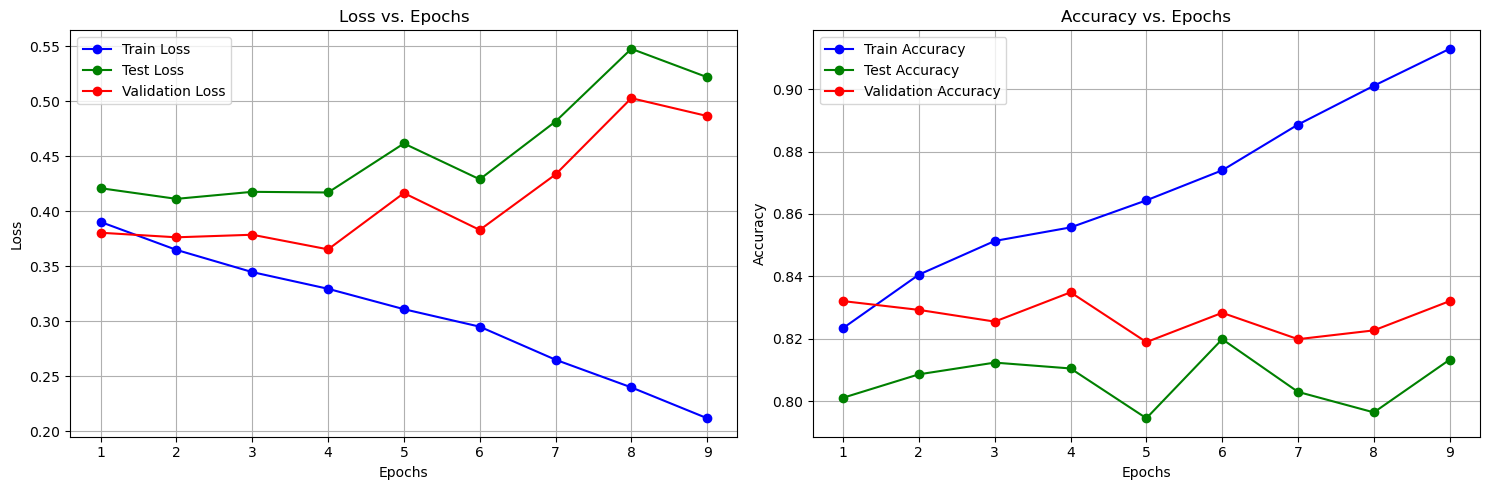

In [60]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [61]:
# Final evaluation on the validation set to compare whether model is correct
val_loss, val_accuracy = evaluate_model(model, val_loader, bert_model)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.3652, Validation Accuracy: 0.8349


In [62]:
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader, bert_model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")  

Test Loss: 0.4169, Test Accuracy: 0.8105


## Answers to Question 3(e) and 3(f)

## 3(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set using your improved model

## Final Result
| Method              | Test Accuracy | 
|---------------------|-----------------------|
| Attention BiLSTM Model with Dropout    | **0.8105**             | 

## Final Improvement Strategy for Part 3.5

---

### Model Architecture
1. **BERT Embeddings**:
   - Provides **contextualised word embeddings** that adapt based on the word's meaning in the sentence.
   - Example: The word "bank" in "river bank" vs. "money in the bank" will have different embeddings, capturing its context dynamically.

2. **BiLSTM Layer with Dropout**:
   - Captures **bidirectional dependencies** by processing the input sequence both forward and backward.
   - Ensures the model understands relationships between words in the entire sequence, not just in one direction.
   - Dropout after attention prevents overfitting when learning from high-dimensional BERT embeddings and reduces reliance on specific patterns in the data.

3. **BERT + BiLSTM Combination**
	- **BERT embeddings** provide **rich contextual information**, ensuring that word representations are sensitive to their context.
	- **BiLSTM** captures **sequential patterns** and **bidirectional relationships** in the text, complementing BERT's static embeddings for each sequence.

4. **Combined Attention Mechanism**:
   - Applied to the **merged output** of forward and backward BiLSTM states.
   - Attention addresses the challenges of:
     - **Long-Range Dependencies**:
       Traditional models often fail to connect distant words due to vanishing gradients or fixed receptive fields (e.g., in CNNs).
       Attention allows the model to selectively focus on relevant words, regardless of their distance in the sequence.
     - **Context Understanding**:
       Attention assigns weights to tokens, enabling the model to emphasise critical words or phrases dynamically based on their relevance.
       Example: For sentiment analysis, the model might focus on words like "excellent" or "horrible" while ignoring filler words like "the" or "and."
   - Improves interpretability by providing insight into which tokens contribute most to predictions.

5. **Fully Connected Layer**:
   - Processes the attention-weighted token representations and outputs the sentiment classification (e.g., positive or negative).

---

### Summary
This architecture combines **BERT embeddings**, **BiLSTM layers**, and a **combined attention mechanism** to:
- Address the limitations of traditional models in capturing **long-range dependencies**.
- Dynamically assign focus to **relevant tokens**, improving context understanding and interpretability.
- Regularise the model with **dropout**, ensuring robust generalisation.

Hence, through these components we are able to achieve a test accuracy of ```81.05%``` which is the highest among all the models we have trained and analysed.


## 3(f) Compare the results across different solutions above and describe your observations with possible discussions

### Result from Part 3.2
| Method              | Test Accuracy in Part 2 | Test Accuracy in Part 3.1 | Test Accuracy in Part 3.2 |
|---------------------|-----------------------|-------------------------|-------------------------|
| RNN Last State      | 0.6135               | 0.7167               | 0.7261 |

---

### Result from Part 3.3
| Method              | Test Accuracy (2 Layers) | Test Accuracy (3 Layers) | Test Accuracy (4 Layers) |
|---------------------|-----------------------|-------------------------|-------------------------|
| BiLSTM Model              | 0.7402               | 0.7411               | 0.7430                         |
| BiLSTM with Dropout Model | 0.7523               | 0.7533               | 0.7570                         |
| BiGRU Model               | 0.7533               | 0.7345               | 0.7420                         |

---

### Result from Part 3.4
| Method              | Test Accuracy | 
|---------------------|-----------------------|
| CNN Model    | 0.7833              | 

---

### Result from Part 3.5
| Method              | Test Accuracy | 
|---------------------|-----------------------|
| Attention BiLSTM Model with Dropout    | **0.8105**             | 

---

### Why It Works Better

#### 1. Comparison to Models analysed from previous parts

| **Feature**               | **RNN**         | **CNN**         | **BiLSTM**      | **Combined Attention BiLSTM + BERT** |
|----------------------------|-----------------|-----------------|-----------------|--------------------------------------|
| **Embedding Type**         | FastText (static) | FastText (static) | FastText (static) | BERT (contextual)                   |
| **Contextual Awareness**   | Limited         | Limited         | Bidirectional   | Bidirectional + Contextual          |
| **Focus on Relevant Tokens**| Uniform         | Local (n-grams) | Uniform         | Attention on most relevant tokens   |
| **Handling Long Sequences**| Poor            | Fixed receptive field | Good       | Excellent                           |
| **Interpretability**       | Limited         | Limited         | Limited         | High (via attention weights)        |

#### 2. Key Advantages
1. **Contextual Embeddings (BERT vs. FastText)**:
   - FastText embeddings are **static** and fail to adapt to context.
   - BERT embeddings are **dynamic**, improving handling of ambiguity and complex sentences.

2. **Relevance via Attention**:
   - Attention mechanism focuses on the most critical tokens in the sequence, reducing noise.

3. **Bidirectionality**:
   - BiLSTM captures both forward and backward dependencies, while attention emphasizes their most important aspects.

### Conclusion
The **Combined Attention BiLSTM + BERT Embeddings** model outperforms the standalone RNNs, CNNs, BiLSTM, and BiGRU with FastText embeddings with the highest accuracy of ```81.05%```

These are the key summary points how this model surpassed the other models:
- Leveraging **BERT embeddings** for contextual understanding.
- Focusing on **relevant tokens** via the attention mechanism.
- Efficiently utilizing **bidirectional dependencies**.
- Providing better generalization with **dropout regularization**.